Otsu threshold = 11.0


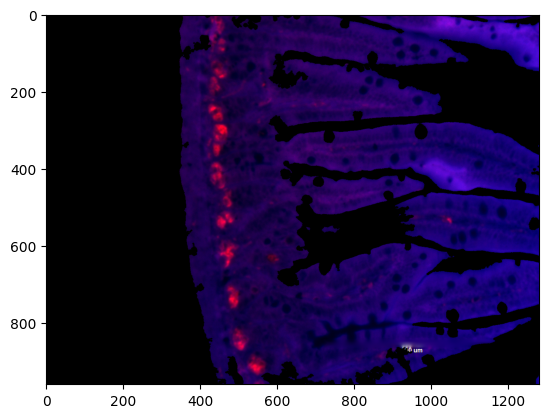

In [ ]:
from pathlib import Path
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import entropy as scipy_entropy
from scipy.ndimage import binary_fill_holes

# Cell 0: load and display a TIFF using tifffile

# explicit notebook path (adjust only if your notebook moved)
notebook = Path(r"C:\Users\admin\Documents\Pierre lab\projects\Colustrum-ABX\lysozyme stain quantification\code\component development\rebuild.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent

# construct TIFF path relative to the project root
tif_path = project_root / "lysozyme images" / "Jej LYZ" / "G2" / "G2EL - 3.tif"

if not tif_path.exists():
    raise FileNotFoundError(f"TIFF not found: {tif_path.resolve()}")

def remove_rectangles( image, white_thresh=240, aspect_low=0.2, aspect_high=5.0,
                        dilation_kernel=(15, 15), inpaint_radius=15):
    """Remove rectangular artifacts from image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    _, bm = cv2.threshold(gray, white_thresh, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(bm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(gray)
    
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        if w == 0 or h == 0: 
            continue
        ar = w / h
        if ar < aspect_low or ar > aspect_high:
            cv2.rectangle(mask, (x, y), (x+w, y+h), 255, -1)
            
    if not mask.any(): 
        return image.copy()
    mask = cv2.dilate(mask, np.ones(dilation_kernel, np.uint8), 1)
    bgr = image[..., ::-1]
    out = cv2.inpaint(bgr, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return out[..., ::-1]

img = remove_rectangles(tifffile.imread(tif_path))  # loads numpy array

# compute Otsu threshold on a grayscale version, erode the mask and hole-fill it, then zero-out background pixels in img

# make a grayscale copy (match the conversion used later so variables stay consistent)
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# initial binary mask (foreground True)
mask = gray_u8 > otsu_thresh

# erode the mask to remove small spurious foreground pixels
ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_eroded = cv2.erode((mask.astype(np.uint8) * 255), ker, iterations=1).astype(bool)

# fill holes in the eroded mask
mask_filled = binary_fill_holes(mask_eroded)

# update mask to the processed version
mask = mask_filled

# set background (where mask is False) to zero in the original img array
if img.ndim == 3 and img.shape[-1] in (3, 4):
    img[~mask] = 0
else:
    img[~mask] = 0
if img.ndim == 3 and img.shape[-1] in (3, 4):
    gray = cv2.cvtColor(img[..., :3], cv2.COLOR_RGB2GRAY)
else:
    gray = np.squeeze(img) if img.ndim >= 2 else img.copy()

gray_u8 = gray.astype(np.uint8)
otsu_thresh, _ = cv2.threshold(gray_u8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = gray_u8 > otsu_thresh  # foreground True

# # set background (where mask is False) to zero in the original img array
# if img.ndim == 3 and img.shape[-1] in (3, 4):
#     img[~mask] = 0
# else:
#     img[~mask] = 0

print(f"Otsu threshold = {otsu_thresh}")
plt.imshow(img)

# extract channels (assuming img is HxWx3 in RGB order)
from skimage.morphology import reconstruction
red_ch = img[..., 0]
blue_ch = img[..., 2]


marker_r = red_ch.astype(np.float32)
other_r = blue_ch.astype(np.float32)
mask_r_dilation = np.maximum(other_r, marker_r)
mask_r_erosion  = np.minimum(other_r, marker_r)

# morphological reconstructions

recon_d_red  = reconstruction(marker_r, mask_r_dilation, method="dilation")
recon_e_red  = reconstruction(marker_r, mask_r_erosion,  method="erosion")


recon_d_red_u8  = np.clip(recon_d_red,  0, 255).astype(np.uint8)
recon_e_red_u8  = np.clip(recon_e_red,  0, 255).astype(np.uint8)

import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt


import numpy as np


from skimage import morphology

# extract channels (assuming img is HxWx3 in RGB order)
red_ch = img[..., 0]

diff_r =  red_ch.astype(int) > recon_e_red_u8.astype(int)
diff_r = morphology.remove_small_objects(morphology.binary_erosion(diff_r, footprint=np.ones((3, 3))), min_size=100)



def minmax01(x, axis=None, eps=1e-12):
    x = np.asarray(x, dtype=float)
    lo = np.nanmin(x, axis=axis, keepdims=True)
    hi = np.nanmax(x, axis=axis, keepdims=True)
    return (x - lo) / np.maximum(hi - lo, eps)



# create boolean mask where abs(dilation - red) > red
abs_diff = np.abs(recon_d_red_u8.astype(int) - red_ch.astype(int))
mask_gt_red = abs_diff > red_ch.astype(int)

# quick stats
n_pixels = mask_gt_red.size
n_true = int(mask_gt_red.sum())


# erode the binary mask a bit to "shrink it back"
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
erosion_iters = 2  # adjust if you want stronger/weaker erosion

# prepare uint8 mask for morphological ops
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=erosion_iters)
mask_gt_red_eroded = mask_eroded_u8.astype(bool)


from scipy.ndimage import distance_transform_edt

# Combine diff_r and mask_gt_red into a labeled numpy array
combined_labels = np.zeros_like(diff_r, dtype=int)

# Assign unique labels to diff_r and mask_gt_red
combined_labels[mask_gt_red_eroded] = 2  # Label for mask_gt_red
combined_labels[diff_r] = 1       # Label for diff_r (takes precedence)

# --- helpers ---
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)

# expand combined labels (0=bg, 1=classA, 2=classB e.g.)
expanded_labels = expand_labels(combined_labels, distance=100)

# markers from diff_r (0 = not a marker)
labeled_crypts, _ = ndi_label(expanded_labels == 1)
plt.imshow(labeled_crypts, cmap="tab20")
plt.title("Labeled Crypts") 
plt.axis("off")
plt.show()